<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_Exam3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd

import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/003_m1.csv')


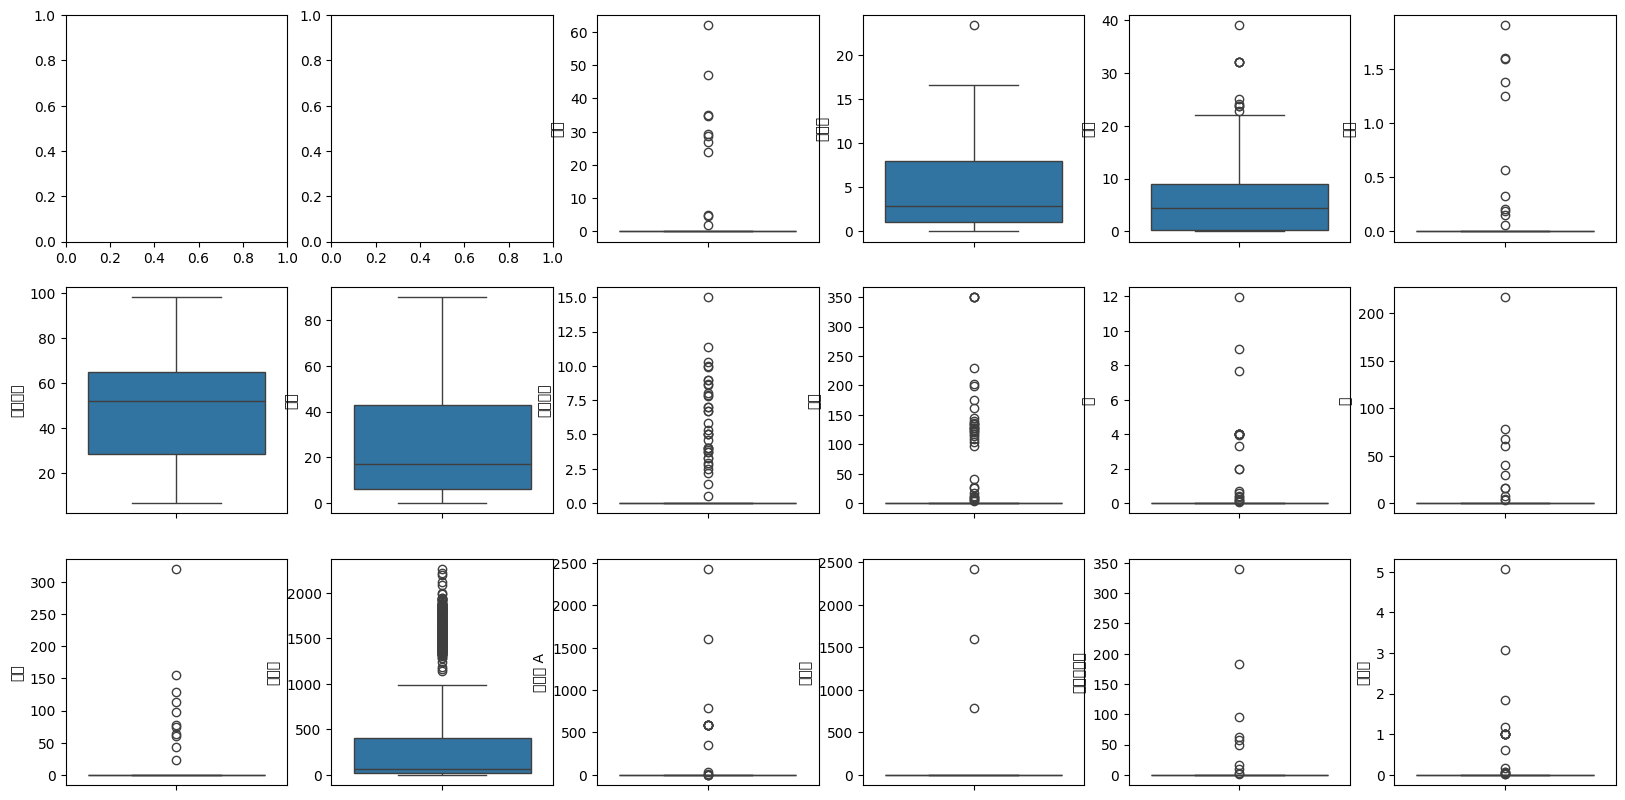

In [3]:
df.columns = [col.split('(')[0] for col in df.columns]

cols = df.columns
remove = ['식품명' , '업체명']

## columns 중 필요없는 컬럼 지우기
cols = [col for col in cols if col not in remove]
fig, axes = plt.subplots(3, 6, figsize=(20, 10))

for i, ax in enumerate(axes.flat[:]) :
  col_i = df[cols].columns[i]

  if df[col_i].dtypes == 'float64' :
    sns.boxplot(df[col_i], ax= ax)


기계학습2
식품명을 모르는 상태에서 영양성분표를 바탕으로 데이터를 군집화 작업을 하려한다.
군집 모델링 전 차원 축소가 필요한지 확인하고 필요하다면 그 근거를 작성하고 차원축소를 진행하라.

#### 차원 축소를 확인하려면 공선성 확인하는 것은 - 회귀분석에서만 적용

- 군집 분석일 때의 차원 축소 여부를 확인하기 위해서는 주로 "상관관계 분석" 과 "차원의 효율성"을 고려해 차원 축소를 결정
1. 차원의 저주 - 데이터 포인트 간의 거리가 멀어져 군집과가 어려워짐
2. 상관관계 분석 : 변수간 높은 상관 관계가 있는 것을 중복된 정보를 제거하기 위함
3. 방법 : PCA , t-SNE, UMAP

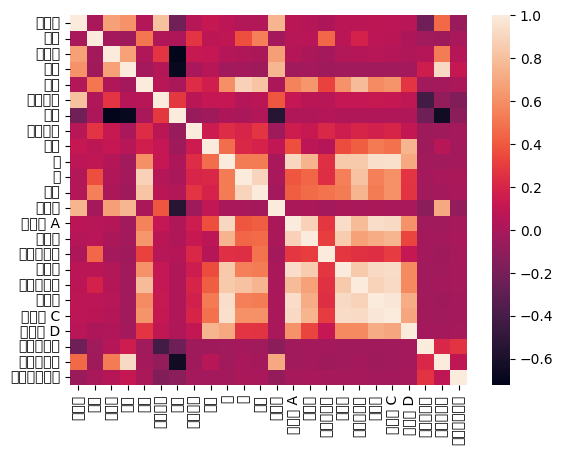

In [4]:
df2 = df.drop(columns = ['식품명','영양성분함량기준량','업체명'])

cor_table = df2.corr().unstack().reset_index()
cor_table.columns  = ['Corr1','Corr2', 'Corr']
cor2 = cor_table[cor_table['Corr1'] != cor_table['Corr2']].pivot_table(index = 'Corr1', columns = 'Corr2', values = 'Corr')

#cor2[cor2.apply(lambda x : (x > 0.6).any() , axis = 1 )]

sns.heatmap(df2.corr())
plt.show()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
var,0.172834,0.083032,0.019706,0.013188,0.010629,0.004411,0.003638,0.003404,0.002133,0.001793,...,0.000514,0.000305,0.000178,0.000132,0.000092,0.000047,0.000037,0.000019,0.000015,1.619560e-07
ratio,0.539348,0.259112,0.061495,0.041154,0.033168,0.013765,0.011354,0.010623,0.006657,0.005595,...,0.001605,0.000950,0.000554,0.000412,0.000287,0.000148,0.000115,0.000059,0.000047,5.054027e-07
cumsum,0.539348,0.798461,0.859956,0.901110,0.934278,0.948043,0.959397,0.970020,0.976677,0.982272,...,0.997427,0.998378,0.998932,0.999344,0.999631,0.999779,0.999894,0.999953,0.999999,1.000000e+00


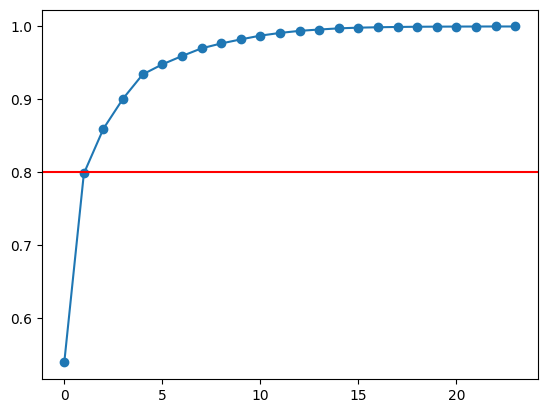

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(MinMaxScaler().fit_transform(df2))

pca_t = pd.DataFrame(
    {'var' : pca.explained_variance_ ,
     'ratio' : pca.explained_variance_ratio_ ,
     'cumsum' : pca.explained_variance_ratio_.cumsum()}
)

display(pca_t.T)
plt.plot(pca_t['cumsum'], '-o')
plt.axhline(y = 0.8, color = 'r')
plt.show()



In [6]:
#  [:,:5] is selecting all rows and the first 5 principal components from the transformed data.
# This is useful when you want to retain only a subset of the principal components (in this case, the first 5) for further analysis or visualization.

pca_df = pca.fit_transform(MinMaxScaler().fit_transform(df2))[:,:5]

### 기계학습3      
위에서 전처리한 데이터를 기준으로 Kmeans 군집을 실시하라. 최적의 군집 수를 도출한 근거를 설명하라.         
해당 군집 결과를 PCA를 진행한 두개의 축위에 각 클러스터별 다른 색상으로 산점도를 그려라.

그래프의 평균 실루엣 계수:

전체 평균 실루엣 계수가 높을수록 군집화의 품질이 좋다는 것을 나타냅니다. 일반적으로 0.5 이상이면 군집화가 잘 되었다고 할 수 있습니다.

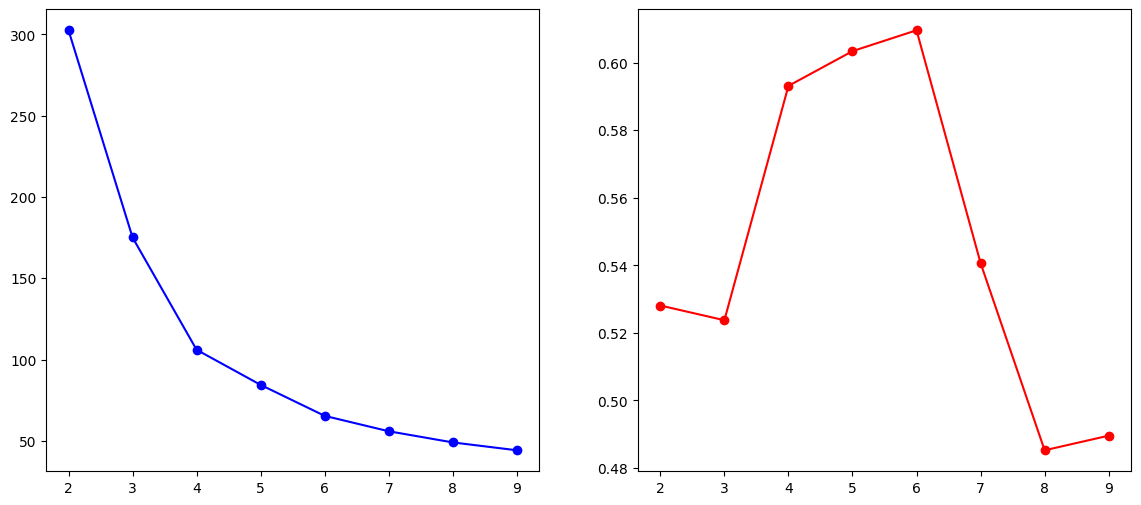

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score , silhouette_samples


iner_lst =[]
sil_score = []
k_range = range(2,10)

for K in k_range :
  kmeans = KMeans(n_clusters = K, random_state = 1234).fit(pca_df)
  iner_lst.append(kmeans.inertia_)
  sil_score.append(silhouette_score(pca_df, kmeans.labels_))


plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
plt.plot(k_range, iner_lst , 'bo-')


plt.subplot(1,2,2)
plt.plot(k_range, sil_score , 'ro-')


- 실루엣 계수 해석 하기
  1. 값이 "1"에 가까움 : 잘된 군집
  2. 값이 "0"에 가까움 : 두 집간의 경게에 있는 경우
  3. 값이 "-1"에 가까움 : 잘못된 군집에 속하거나, 올바룬 군집이 아님

- 평균 실루엣 계수 (컬럼과 Labels로 평가)
 일반적으로 0.5 이상이면 군집화가 잘 되었다고 할 수 있다.

In [8]:
# 기울이가 소실되는 부분이 3,4임으로 4로 지정한다.

km4  = KMeans(n_clusters= 4, random_state = 345).fit(pca_df)

# Cluster Label 구하기
labels = km4.labels_

# PC1, PC2 를 선택 후, 데이터 프레임화
k_df = pd.DataFrame(pca_df[:,:2] , columns  = ['PC1', 'PC2'])
k_df['Labels'] = labels

# Samples 로 지정
s_score = silhouette_samples(k_df[['PC1', 'PC2']], k_df['Labels'])

k_df['Silhouette_Coef'] = s_score
display(k_df)

## 실루엣 계수 구하기
avg_silhou_score = silhouette_score(k_df[['PC1', 'PC2']], k_df['Labels'])
print("평균 실루엣 계수:", avg_silhou_score)

,PC1,PC2,Labels,Silhouette_Coef
0,0.826996,0.053505,2,0.871664
1,0.726186,0.043426,2,0.839258
2,0.713301,0.053262,2,0.816207
3,0.817578,0.005622,2,0.886119
4,0.898891,-0.008530,2,0.838671
...,...,...,...,...
1845,-0.385434,0.185160,1,0.700732
1846,-0.344702,0.324301,1,0.778125
1847,-0.355402,0.313897,1,0.781149
1848,-0.209801,0.291096,1,0.615399


평균 실루엣 계수: 0.6455864793076592


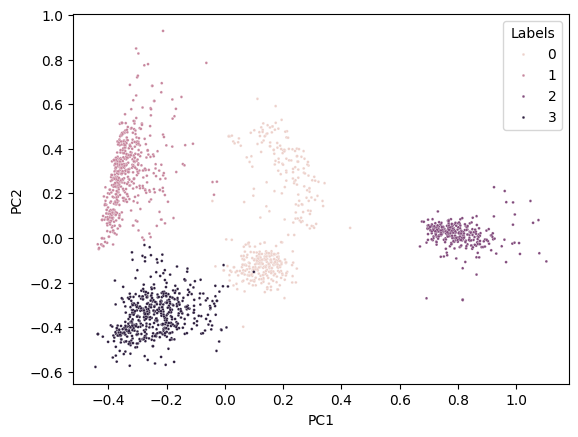

In [9]:
sns.scatterplot(x = k_df['PC1'], y = k_df['PC2'], hue = k_df['Labels'], s = 4)
plt.show()

### 기계학습4
2에서 전처리한 데이터를 3에서 추출한 최적군집 숫자로 계층적 군집분석을 실시하라.    
모델링시 군집간 거리 4가지 방법(최소값,최대값,평균간 거리, 평균)으로 다르게 하여 군집분석을 실시하고    
3에서 추출한 PCA 축상에 군집별 산점도를 출력하라

In [10]:
import scipy.cluster.hierarchy as sch

pca_df = pca.fit_transform(MinMaxScaler().fit_transform(df2))[:,:5]

# 1) Method lst

linkage_method = ['single' ,
                  'complete',
                  'average',
                  'centroid']

num_clusters= 4

lst = {}
for method in linkage_method :
  Z = sch.linkage(pca_df, method= method)
  clusters = sch.fcluster(Z, num_clusters , criterion= 'maxclust')

  lst[method] = pd.Series(clusters)

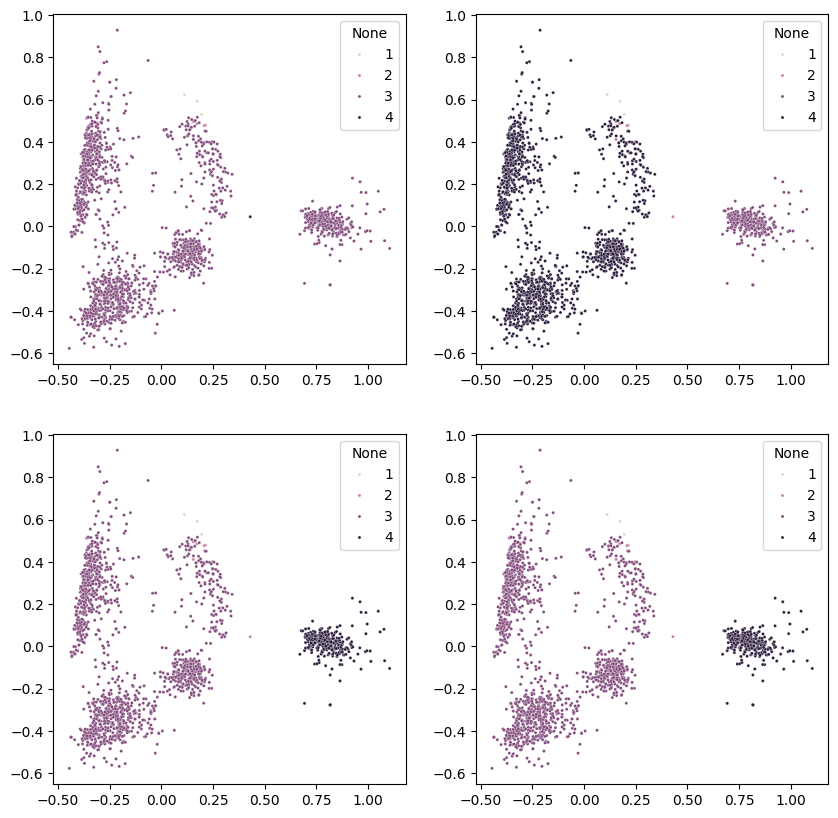

In [11]:
fig, axes  = plt.subplots(2,2 ,figsize = (10,10))

for i, ax in enumerate(axes.flat) :
  sns.scatterplot(x = pca_df[:,0],  y = pca_df[:,1], hue = lst[linkage_method[i]], ax = ax , s = 5)

plt.show()

서울특별시 전월세가
dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/003_m2.csv
출처 : https://data.seoul.go.kr/dataList/OA-21276/S/1/datasetView.do 후처리

23년도 강서구의 전월세 실거래가 데이터이다.
데이터를 바탕으로 총 소모비용 ( 보증금 + 임대료 * 계약기간(월))을 예측하는 모델을 만들려고 한다.

In [12]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/003_m2.csv')
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25530 entries, 0 to 25529
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   자치구명     25530 non-null  object 
 1   법정동명     25530 non-null  object 
 2   지번       25530 non-null  object 
 3   층        25530 non-null  int64  
 4   계약일      25530 non-null  int64  
 5   전월세구분    25530 non-null  object 
 6   보증금(만원)  25530 non-null  int64  
 7   임대료(만원)  25530 non-null  int64  
 8   건축년도     25530 non-null  float64
 9   건물용도     25530 non-null  object 
 10  계약기간     25530 non-null  object 
 11  임대평수     25530 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 2.3+ MB


In [13]:
df['end'] = pd.to_datetime(df['계약기간'].str.split('~').str[1] , format = '%y.%m'  )
df['start'] = pd.to_datetime(df['계약기간'].str.split('~').str[0], format = '%y.%m')
df['계약일'] = pd.to_datetime(df['계약일'].astype(str))
df['건축년도'] = pd.to_datetime(df['건축년도'].astype(str).str.split('.').str[0]).dt.year


EDA </br>

모델링을 위한 데이터 전처리를 시행하라. 추가로 건물용도 마다 각각 여러 수치형변수(임대평수, 건물 건축 기간(2024년기준), 소모비용)간의 통계적 차이가 있는지 확인하라

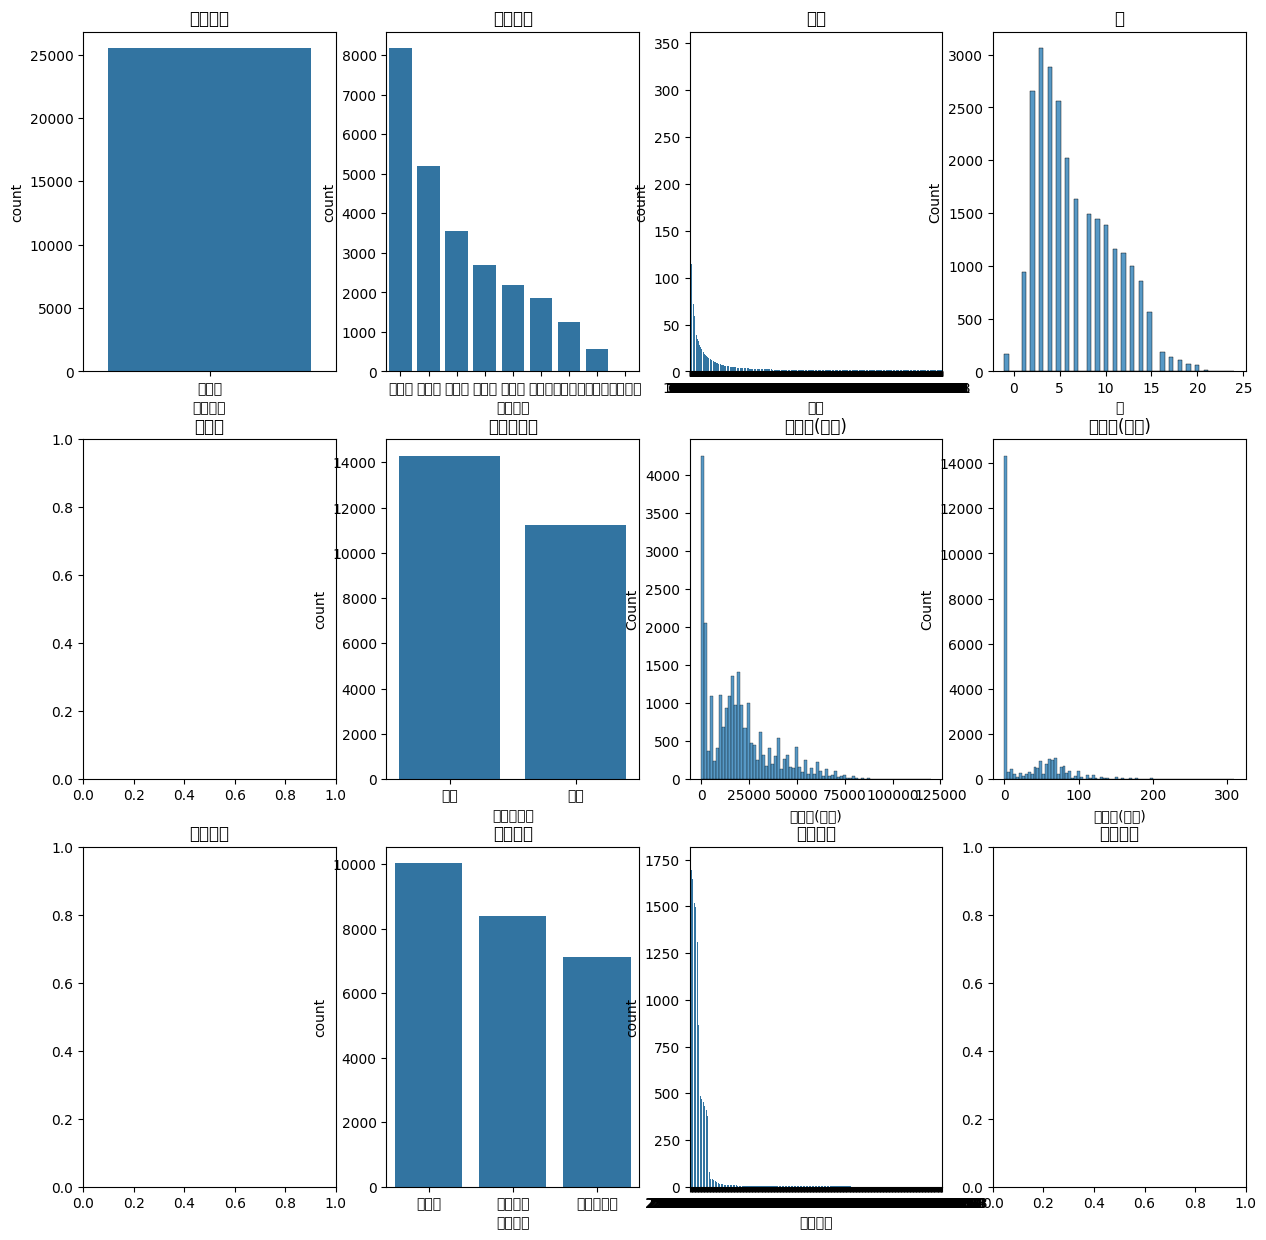

In [14]:
df.columns

str_cols = ['자치구명', '법정동명', '지번', '층', '건물용도']
num_cols = ['보증금(만원)', '임대료(만원)' ,'임대평수' ]

# EDA 를 위한 column type 변경
[ df[col].astype('str') for col in str_cols if col in str_cols]
[ df[col].astype('int') for col in str_cols if col in num_cols]

fig, axes = plt.subplots(3,4, figsize = (15,15))

for i, ax  in enumerate(axes.flat[:]) :
  col_i = df.columns[i]

  if df[col_i].dtypes == 'object' :
    target_cnt = df[col_i].value_counts()
    sns.barplot(x =target_cnt.index , y = target_cnt, ax = ax)


  elif df[col_i].dtypes == 'int':
    sns.histplot(data = df[col_i], ax = ax)

  ax.set_title(col_i)

plt.show()

건물용도 마다 각각 여러 수치형변수(임대평수, 건물 건축 기간(2024년기준), 소모비용)간의 통계적 차이

In [16]:
display(df['건물용도'].value_counts() )


# 1. 건물 건축 기간 (2024년 기준)
df['건물건축기간'] = 2024 - df['건축년도']

# 2. 소모 비용 계산   ( 보증금 + 임대료 * 계약기간(월))
df['계약기간_월'] = (df['end'].dt.year - df['start'].dt.year) * 12 + (df['end'].dt.month - df['start'].dt.month)

df['소모비용'] =  (df['보증금(만원)'] + df['임대료(만원)'] + df['계약기간_월'] )

# 3.F_oneway
check_cols = ['임대평수', '소모비용','계약기간_월']

from scipy import stats

# 1.1 건물 용도 Unique value
types = df['건물용도'].unique()

for col in check_cols :
  groups = [df[df['건물용도'] == use][col] for use in types]
  f_stat, p_val = stats.f_oneway(*groups)

  print(f"F-statistic for {col}: {f_stat:.2f}" )
  print(f"P-value for {col}: {p_val:.6f}")

  if p_val < 0.05 :
    print('건물용도에 따른 차이가 있다')
  else :
    print()



,count
건물용도,
아파트,10033
오피스텔,8383
연립다세대,7114


F-statistic for 임대평수: 8773.55
P-value for 임대평수: 0.000000
건물용도에 따른 차이가 있다
F-statistic for 소모비용: 6001.48
P-value for 소모비용: 0.000000
건물용도에 따른 차이가 있다
F-statistic for 계약기간_월: 4477.16
P-value for 계약기간_월: 0.000000
건물용도에 따른 차이가 있다


xgb,lightgbm,randomforest 각 모델을 학습하고 각 모델별로 주요 변수들을 확인하고 해석하라

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error , r2_score

In [71]:
from sklearn.preprocessing import OneHotEncoder

select_col = ['자치구명', '법정동명','전월세구분', '보증금(만원)', '임대료(만원)', '임대평수' ,'건물건축기간', '계약기간_월', '소모비용']
df_model = df[select_col]

## Object 형태의 필드인 컬럼만 추출
cate_df = df_model.loc[:, df_model.dtypes == 'object']
cate_df2 = pd.get_dummies(cate_df, dtype= 'int')


## Numeric 형태의 필드만 추출
num_df = df_model.loc[:, df_model.dtypes != 'object']
ss = StandardScaler()

num_df2 = pd.DataFrame(ss.fit_transform(num_df) , columns  = num_df.columns)

f_df = pd.concat([num_df2, cate_df2], axis = 1)



## 훈련 데이터

X_ = f_df.drop(columns  = '소모비용' ,axis = 1)
y = f_df['소모비용']
x_train, x_test, y_train, y_test = train_test_split(X_, y, test_size = 0.3 , random_state = 1234)


## Modeling
xgb = XGBRegressor(random_state = 12)
light = LGBMRegressor(n_estimators = 400)
random = RandomForestRegressor()


xgb.fit(x_train, y_train)
light.fit(x_train, y_train)
random.fit(x_train, y_train)

x_pred = xgb.predict(x_test)
l_pred = light.predict(x_test)
r_pred = random.predict(x_test)

x_r2 = r2_score(x_pred, y_test)
x_mse = mean_squared_error(y_test, x_pred, squared = False)

l_r2 = r2_score(l_pred, y_test)
l_mse = mean_squared_error(y_test, l_pred, squared = False)

r_r2 = r2_score(r_pred, y_test)
r_mse = mean_squared_error(y_test, r_pred, squared = False)


models_result = pd.DataFrame( {'xgb' : [x_r2, x_mse],
               'light' : [l_r2, l_mse],
               'Random_Forest' : [r_r2, r_mse]},
              index = ['R2_Score', 'MSE'])

display(models_result)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 17871, number of used features: 16
[LightGBM] [Info] Start training from score 0.004920


,xgb,light,Random_Forest
R2_Score,0.999251,0.999798,0.999999
MSE,0.027169,0.014094,0.000960


<BarContainer object of 17 artists>

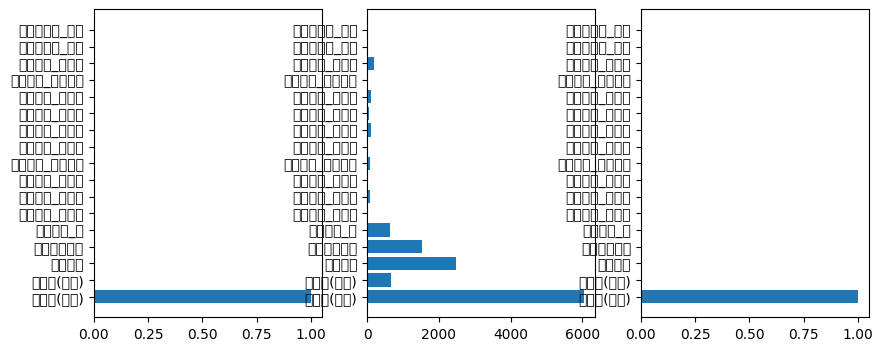

In [76]:
## Feature Importance
figs, ax = plt.subplots(1,3, figsize = (10, 4))
ax[0].barh(xgb.feature_names_in_ , xgb.feature_importances_)
ax[1].barh(light.feature_name_ , light.feature_importances_)
ax[2].barh(random.feature_names_in_ , random.feature_importances_)

### 통계1     
학교내 학생들의 시험 점수를 나타낸 것이다. 성별과 학년이 점수에 대해 가지는 주효과 교호작용효과를 알아보고자 한다.    
(1) 주효과와 교호작용 효과에 대한 가설 설정

가. 교호작용 검정
1. 귀무가설 : 성별과 학년간에는 교호작용이 없다.
2. 대립가설 : 성별과 학년간에는 교호작용이 있다.

나. 주효과 검정
1. 귀무 : 성별에따른 점수의 차이는 존재하지 않는다.
2. 대립 : 성별에따른 점수의 차이는 존재한다.

3. 귀무 : 학년에 따른 점수의 차이는 존재하지 않는다.
4. 대립 : 학년에 따른 점수의 차이는 존재한다.

(2) 통계검정을 사용하기 위한 사전 조건 확인    
(3) 통계검정

In [82]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/003_s4.csv')

# 1. 정규성 검토
from scipy.stats import shapiro
s_table = df.groupby(['성별','학년'])['점수'].apply(lambda x : shapiro(x).pvalue).reset_index().rename(columns = {'점수':'p-val'})
display(s_table)

# 2. 등분산성 검토
from scipy.stats import levene

grps = []
for name , g in df.groupby(['성별', '학년']) :
  grps.append(g['점수'])

levene(*grps)

,성별,학년,p-val
0,남학생,1학년,0.834558
1,남학생,2학년,0.101498
2,남학생,3학년,0.816519
3,여학생,1학년,0.999749
4,여학생,2학년,0.188079
5,여학생,3학년,0.772170


LeveneResult(statistic=0.7159090909090906, pvalue=0.6164463698916796)

In [84]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

ano = ols('점수 ~  C(성별) * C(학년)' , data = df).fit()
anova_lm(ano)

,df,sum_sq,mean_sq,F,PR(>F)
C(성별),1.0,13.444444,13.444444,0.829335,0.369724
C(학년),2.0,478.166667,239.083333,14.748115,0.000035
C(성별):C(학년),2.0,174.055556,87.027778,5.368403,0.010163
Residual,30.0,486.333333,16.211111,NaN,NaN


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------------
남학생_1학년 남학생_2학년      1.5 0.9864  -5.5704  8.5704  False
남학생_1학년 남학생_3학년  -3.3333 0.7067 -10.4038  3.7371  False
남학생_1학년 여학생_1학년   7.1667 0.0455   0.0962 14.2371   True
남학생_1학년 여학생_2학년   1.3333  0.992  -5.7371  8.4038  False
남학생_1학년 여학생_3학년  -6.6667 0.0735 -13.7371  0.4038  False
남학생_2학년 남학생_3학년  -4.8333 0.3247 -11.9038  2.2371  False
남학생_2학년 여학생_1학년   5.6667 0.1757  -1.4038 12.7371  False
남학생_2학년 여학생_2학년  -0.1667    1.0  -7.2371  6.9038  False
남학생_2학년 여학생_3학년  -8.1667 0.0163 -15.2371 -1.0962   True
남학생_3학년 여학생_1학년     10.5 0.0012   3.4296 17.5704   True
남학생_3학년 여학생_2학년   4.6667 0.3619  -2.4038 11.7371  False
남학생_3학년 여학생_3학년  -3.3333 0.7067 -10.4038  3.7371  False
여학생_1학년 여학생_2학년  -5.8333 0.1534 -12.9038  1.2371  False
여학생_1학년 여학생_3학년 -13.8333    0.0 -20.9038 -6.7629   True
여학생_2학년 여학생_3학년     -8.0 0.0194 -15.0704 -0.9296

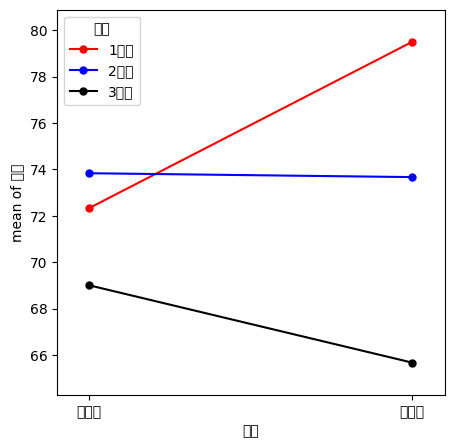

In [97]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.graphics.factorplots import interaction_plot

mc = MultiComparison(df['점수'], df['성별'] + "_" + df['학년'].astype(str))
result = mc.tukeyhsd(alpha=0.05)
print(result)


fig, ax = plt.subplots(figsize = (5,5))
fig = interaction_plot(df['성별'],
                       df['학년'],
                       df['점수'] ,
                       colors = ['red','blue','black'],
                       ms = 10,
                       ax = ax)

### 통계2      
일자별 장마감시간의 주식의 상승과 하락을 추적한 데이터이다.     
주가 변동이 무작위 인지 특정 경향성을 가지는지 통계적으로 확인하려 한다.       

(1) 가설설정     
(2) 검정 통계량 확인 및 분석     

dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/003_s2.csv

In [118]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/003_s2.csv',index_col=0)
df.head()

from statsmodels.sandbox.stats.runs import runstest_1samp

## 순서가 무작위인지 아닌지 검정하는데 사용 : 특정 패턴을 가지는지 아닌지
## 귀무가설 : 데이터가 무작위로 생성되었다.
#  대립가설 : 데이터는 무작위로 생성되지 않았다.
df2 = df.reset_index(drop = True)
dummies= df2.iloc[:,0].apply(lambda x : 1 if x == '상승' else 0)


runstest_1samp(list(dummies))


(1.671732172810527, 0.09457714696436235)

### 통계3    
연구자가 새로운 수면 개선 약을 개발했으며, 이 약의 효과를 검증하기 위해 10명의 피험자에게 일주일 동안 매일 밤 약을 복용하도록 하고, 복용 전과 복용 후의 평균 수면 시간을 비교했다. 연구자는 약이 수면 시간에 유의미한 변화를 가져다주었는지 확인하고 싶어 한다.      
(1) 가설 설정     
(2) 통계 검정

| 피험자 | 복용 전 평균 수면 시간(시간) | 복용 후 평균 수면 시간(시간) |
|---|------------------|------------------|
| 1 | 6 | 7 |
| 2 | 7 | 8 |
| 3 | 6.5 | 6.8 |
| 4 | 5 | 6.5 |
| 5 | 7 | 7.5 |
| 6 | 5.5 | 5 |
| 7 | 6.7 | 7 |
| 8 | 6.2 | 6.8 |
| 9 | 7 | 7.2 |
| 10 | 5.5 | 6 |

In [122]:
# Ho) 수면 시간에 유의미한 변화를 가져가 주지 않았다.
# H1) 수면 시간에 유의미한 변화를 주었다.
from scipy.stats import wilcoxon

before = [6, 7, 6.5, 5, 7, 5.5, 6.7, 6.2, 7, 5.5]
after = [7, 8, 6.8, 6.5, 7.5, 5, 7, 6.8, 7.2, 6]

wilcoxon(before, after)

WilcoxonResult(statistic=5.0, pvalue=0.01953125)

### 통계4
학생 20명을 무작위로 두 그룹으로 나누어 카페인이 학습에 효과가 있는지 확인하려한다. 두 그룹간의 평균 점수 차이가 존재하는지 확인하라    
카페인 그룹 테스트 점수: [88, 92, 94, 95, 96, 97, 91, 93, 98, 94]     
플라시보 그룹 테스트 점수: [81, 83, 84, 88, 86, 85, 87, 82, 80, 83]    

(1) 가설설정    
(2) 검정

In [123]:
print('''
 귀무 가서 : 두 그룹간 평균의 점수의 차이는 없다.
 대립 가설 : 두 그룹간 평균 점수의 차이는 있다.
''')

# (2) 검정
caffeine_scores = [88, 92, 94, 95, 96, 97, 91, 93, 98, 94]
placebo_scores = [81, 83, 84, 88, 86, 85, 87, 82, 80, 83]

t_stat, p_value = stats.ttest_ind(caffeine_scores, placebo_scores)

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.3f}")

if p_value < 0.05:
  print("두 그룹 간의 평균 점수 차이가 유의미합니다. (카페인이 학습에 효과가 있을 수 있습니다.)")
else:
  print("두 그룹 간의 평균 점수 차이가 유의미하지 않습니다.")


 귀무 가서 : 두 그룹간 평균의 점수의 차이는 없다. 
 대립 가설 : 두 그룹간 평균 점수의 차이는 있다. 

t-statistic: 7.92
p-value: 0.000
두 그룹 간의 평균 점수 차이가 유의미합니다. (카페인이 학습에 효과가 있을 수 있습니다.)
